## What are Helsinki City bikes?
Helsinki City Bikes are shared bicycles available to the public in Helsinki and Espoo metropolitan areas. The main aim of the Helsinki city bike system is to address the so-called last-mile problem present in all distribution networks. The city bikes were introduced in 2016 as a pilot project with only 46 bike stations available in Helsinki. After becoming popular among the citizens, Helsinki city decided to gradually expand the bike network. In the period between 2017 and 2019, approximately one hundred stations were being added to the network each year. By 2019 the bike network reached its complete state with only 7 stations being added in 2020. As of 2020, there were 3,510 bikes and 350 stations operating in Helsinki and Espoo.

> Since 2016 more than 10.000.000 rides have been made. The total distance of the trips is 25.291.523 kilometres. To put that in perspective 25.3 million kilometres is 65 times the distance to the moon. The total time all residents spent riding the bikes is approximately 280 Years and 4 months.

In order to use the city bikes, citizens purchase access for a day, week or the entire cycling season that lasts from April to November. All passes include an unlimited number of 30-minute bike rides. For an extra fee of 1€/hour, you can use the bike for longer. Bikes are picked up and returned to stations that are located all around Helsinki and Espoo.

In [27]:
import datetime
import calendar

import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import seaborn as sns
import plotly.graph_objects as go

import networkx as nx
import community as community_louvain
from operator import itemgetter

import folium
from folium import plugins

# Custom Colors
MAGENTA = "#6C3483"
GREEN = "#239B56"
BLUE = "#5DADE2"

In [28]:
dataframe = pd.read_csv("data/database.csv", low_memory=False)
dataframe.head()

,departure,return,departure_id,departure_name,return_id,return_name,distance (m),duration (sec.),avg_speed (km/h),departure_latitude,departure_longitude,return_latitude,return_longitude,Air temperature (degC)
0,2020-03-23 06:09:44,2020-03-23 06:16:26,86,Kuusitie,111.0,Esterinportti,1747.000,401.000,0.261,60.195,24.902,60.198,24.927,0.900
1,2020-03-23 06:11:58,2020-03-23 06:26:31,26,Kamppi (M),10.0,Kasarmitori,1447.000,869.000,0.100,60.169,24.931,60.165,24.949,0.900
2,2020-03-23 06:16:29,2020-03-23 06:24:23,268,Porolahden koulu,254.0,Agnetankuja,1772.000,469.000,0.227,60.196,25.054,60.187,25.036,0.900
3,2020-03-23 06:33:53,2020-03-23 07:14:03,751,Vallipolku,106.0,Korppaanmäentie,7456.000,2406.000,0.186,60.228,24.820,60.203,24.899,0.900
4,2020-03-23 06:36:09,2020-03-23 07:04:10,62,Länsisatamankatu,121.0,Vilhonvuorenkatu,7120.000,1679.000,0.254,60.159,24.910,60.186,24.968,0.900


In [29]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12157458 entries, 0 to 12157457
Data columns (total 14 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   departure               object 
 1   return                  object 
 2   departure_id            object 
 3   departure_name          object 
 4   return_id               object 
 5   return_name             object 
 6   distance (m)            float64
 7   duration (sec.)         float64
 8   avg_speed (km/h)        float64
 9   departure_latitude      float64
 10  departure_longitude     float64
 11  return_latitude         float64
 12  return_longitude        float64
 13  Air temperature (degC)  float64
dtypes: float64(8), object(6)
memory usage: 1.3+ GB


In [30]:
dataframe[['departure','return']] =  dataframe[['departure','return']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12157458 entries, 0 to 12157457
Data columns (total 14 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   departure               datetime64[ns]
 1   return                  datetime64[ns]
 2   departure_id            object        
 3   departure_name          object        
 4   return_id               object        
 5   return_name             object        
 6   distance (m)            float64       
 7   duration (sec.)         float64       
 8   avg_speed (km/h)        float64       
 9   departure_latitude      float64       
 10  departure_longitude     float64       
 11  return_latitude         float64       
 12  return_longitude        float64       
 13  Air temperature (degC)  float64       
dtypes: datetime64[ns](2), float64(8), object(4)
memory usage: 1.3+ GB


In [31]:
dataframe = dataframe.rename(columns={'distance (m)': 'distance',
                                     'duration (sec.)': 'duration',
                                     'avg_speed (km/h)':'speed',
                                      'Air temperature (degC)':'temperature',
                                     })
dataframe.head()

,departure,return,departure_id,departure_name,return_id,return_name,distance,duration,speed,departure_latitude,departure_longitude,return_latitude,return_longitude,temperature
0,2020-03-23 06:09:44,2020-03-23 06:16:26,86,Kuusitie,111.0,Esterinportti,1747.000,401.000,0.261,60.195,24.902,60.198,24.927,0.900
1,2020-03-23 06:11:58,2020-03-23 06:26:31,26,Kamppi (M),10.0,Kasarmitori,1447.000,869.000,0.100,60.169,24.931,60.165,24.949,0.900
2,2020-03-23 06:16:29,2020-03-23 06:24:23,268,Porolahden koulu,254.0,Agnetankuja,1772.000,469.000,0.227,60.196,25.054,60.187,25.036,0.900
3,2020-03-23 06:33:53,2020-03-23 07:14:03,751,Vallipolku,106.0,Korppaanmäentie,7456.000,2406.000,0.186,60.228,24.820,60.203,24.899,0.900
4,2020-03-23 06:36:09,2020-03-23 07:04:10,62,Länsisatamankatu,121.0,Vilhonvuorenkatu,7120.000,1679.000,0.254,60.159,24.910,60.186,24.968,0.900


In [32]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
dataframe[["distance", "duration", "temperature"]].describe()

,distance,duration,temperature
count,12157458.000,12157458.000,12141556.000
mean,2295.275,959.775,15.650
std,24520.672,7346.528,5.498
min,-4292467.000,0.000,-5.200
25%,1000.000,344.000,12.300
50%,1739.000,586.000,16.400
75%,2869.000,971.000,19.300
max,3681399.000,5401659.000,32.900


In [33]:
dataframe = dataframe[ 
                    (50 < dataframe['distance']) & (dataframe['distance'] < 10000) &
                    (120 < dataframe['duration']) & (dataframe['duration'] <  18000) &
                    (-20 < dataframe['temperature']) & (dataframe['temperature'] < 50)        
                    ]

dataframe[["distance", "duration", "temperature"]].describe()

,distance,duration,temperature
count,11278850.000,11278850.000,11278850.000
mean,2242.385,783.600,15.637
std,1494.708,795.838,5.495
min,51.000,121.000,-5.200
25%,1121.000,380.000,12.300
50%,1847.000,615.000,16.400
75%,2964.000,991.000,19.300
max,9999.000,17998.000,32.900


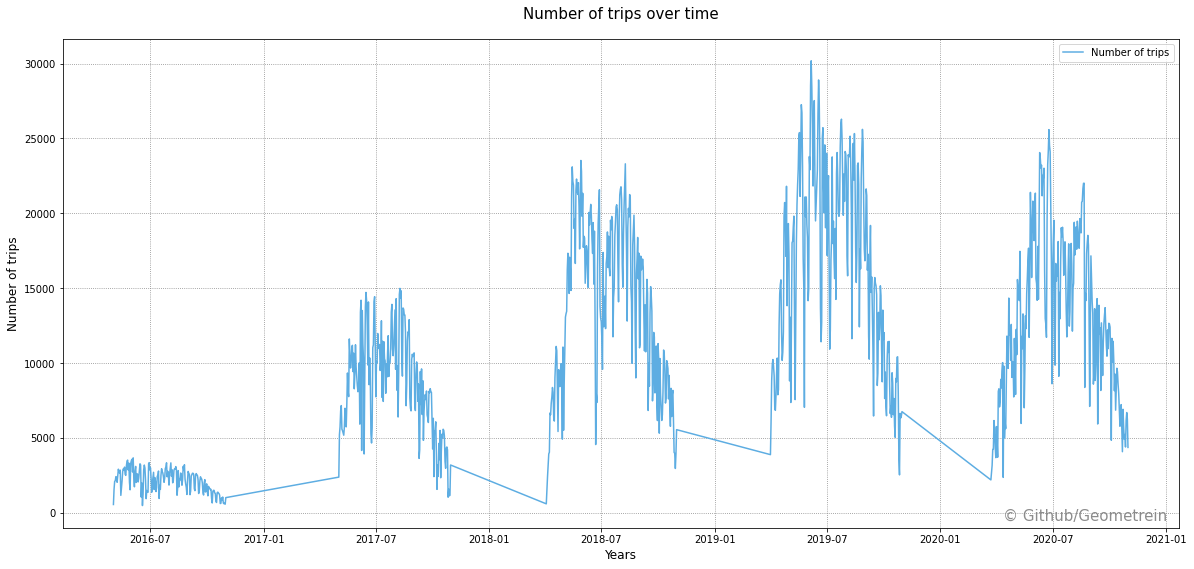

In [34]:
def tripsByYear(dataframe):
    """
    Number of trips over the years
    """
    # Data 
    df = dataframe.copy()
    df_over_time = df.groupby(df['departure'].dt.date).size().reset_index(name='count')

    # Figure
    fig, ax = plt.subplots(figsize=(20,9))
    plt.plot(df_over_time["departure"], df_over_time["count"], color= BLUE)

    # Labels
    ax.set_title("Number of trips over time", fontsize= 15, pad= 20)
    ax.set_ylabel("Number of trips", fontsize=12)
    ax.set_xlabel("Years", fontsize=12)

    # Grid & Legend
    plt.grid(linestyle=":", color='grey')
    plt.legend(["Number of trips"])

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    plt.show()

tripsByYear(dataframe)

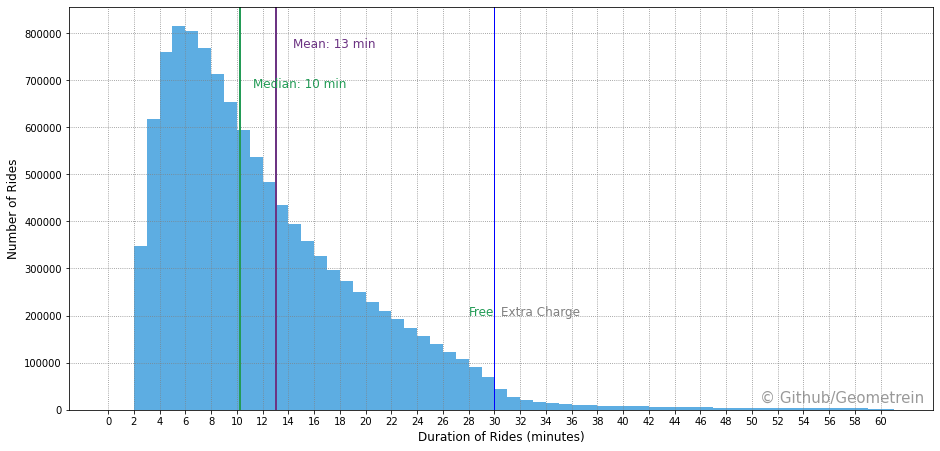

In [35]:
def duration(dataframe):
    """
    """
    df = dataframe.copy()
    
    # Converting seconds to minutes
    df["duration"] = df["duration"]/60
    
    # Filtering relevant data
    duration_data = df["duration"]
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    # Ploting the histogram
    plt.hist(duration_data, bins = range(62), color = BLUE, histtype ="bar")

    # Adding median and mean lines
    plt.axvline(df["duration"].mean(), color=MAGENTA, linestyle='-', linewidth=2 )
    plt.axvline(df["duration"].median(), color=GREEN, linestyle='-', linewidth=2 )
    plt.axvline(x = 30, color="blue", linestyle='-', linewidth=1 )

    # Adding median and mean texts
    min_ylim, max_ylim = plt.ylim()
    plt.text(df["duration"].mean()*1.1, max_ylim*0.9, 'Mean: {:.0f} min'.format(df["duration"].mean()), color = MAGENTA,  fontsize= 12)
    plt.text(df["duration"].median()*1.1, max_ylim*0.8, 'Median: {:.0f} min'.format(df["duration"].median()), color = GREEN, fontsize= 12)
    plt.text(x= 28,y=200000, s="Free", color = GREEN, fontsize= 12)
    plt.text(x= 30.5,y=200000, s="Extra Charge", color = "grey", fontsize= 12)

    # Seting ticks on x axis
    ticks =range(0, 62, 2)
    plt.xticks(ticks)
    # Seting ticks on y axis
    ticks =range(0, 3600, 2000)

    # Labeling Axes
    plt.xlabel("Duration of Rides (minutes)", fontsize= 12, x = 0.5)
    plt.ylabel("Number of Rides", fontsize= 12)

    # Adding Grid
    plt.grid(linestyle=":", color='grey')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.8)

    plt.show()

duration(dataframe)

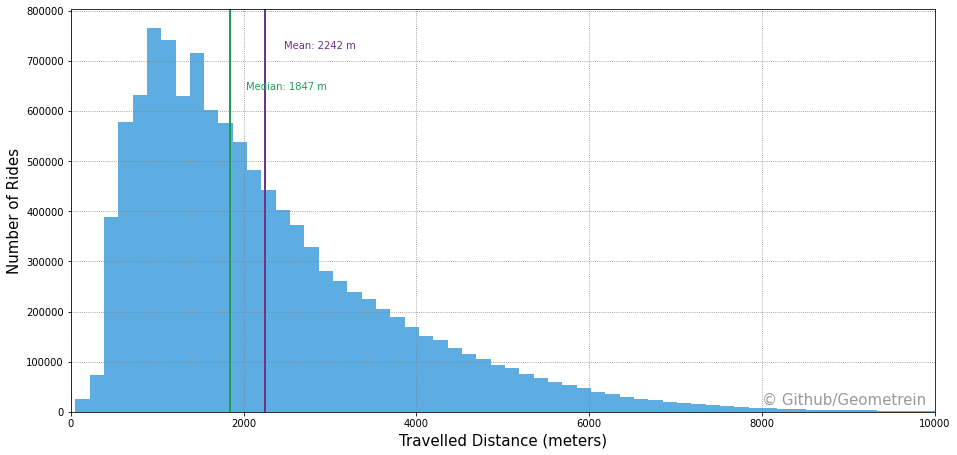

In [36]:
def distance(dataframe):
    """
    
    """
    df = dataframe.copy()
    
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    data = df["distance"]
    plt.hist(data, bins = 60, color = BLUE)


    plt.axvline(df["distance"].mean(), color=MAGENTA, linestyle='-', linewidth=2 )
    plt.axvline(df["distance"].median(), color=GREEN, linestyle='-', linewidth=2 )
    plt.axvline(df["distance"].median(), color=GREEN, linestyle='-', linewidth=2 )

    min_ylim, max_ylim = plt.ylim()

    plt.text(df["distance"].mean()*1.1, max_ylim*0.9, 'Mean: {:.0f} m'.format(df["distance"].mean()), color = MAGENTA,  fontsize= 10)
    plt.text(df["distance"].median()*1.1, max_ylim*0.8, 'Median: {:.0f} m'.format(df["distance"].median()), color = GREEN, fontsize= 10)

    ax.set_xlim([0,10000])

    # Labeling Axes
    plt.xlabel("Travelled Distance (meters)", fontsize= 15, x = 0.5)
    plt.ylabel("Number of Rides", fontsize= 15)

    # Adding Grid
    plt.grid(linestyle=":", color='grey')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.8)

    plt.show()

distance(dataframe)

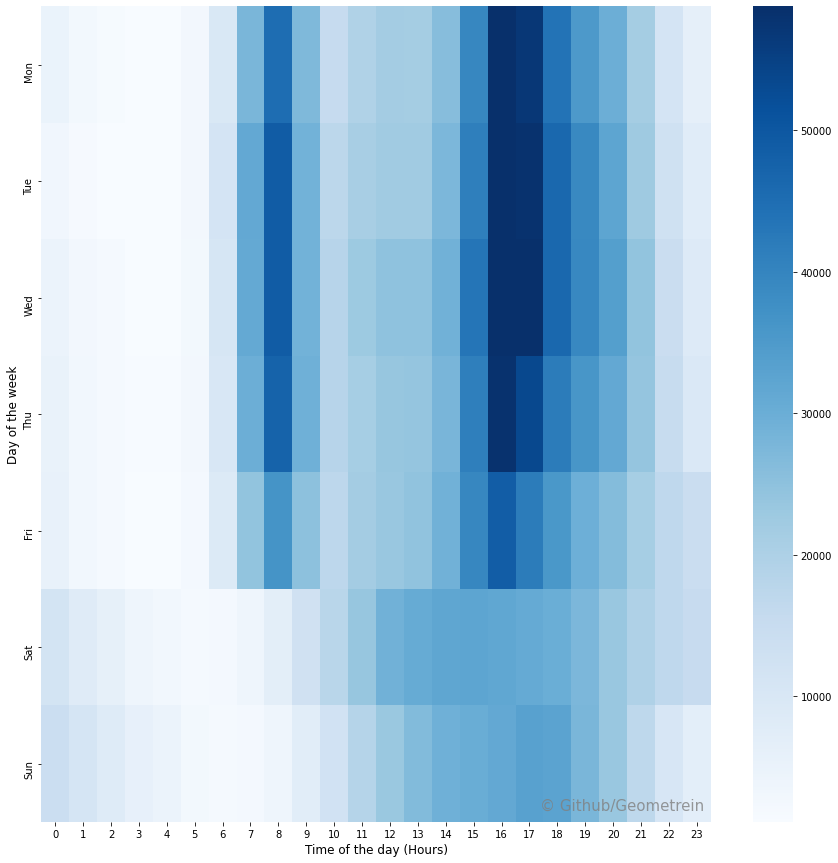

In [37]:
def weekday_heatmap(dataframe, year=2019):
    """
    This function plots the number of trips by weekday and hour of the day.
    """
    weekdays = ["Mon", "Tue","Wed", "Thu", "Fri", "Sat", "Sun"]
    
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]
    df["hour"] = pd.DatetimeIndex(df['departure']).hour
    df["weekday"] = pd.DatetimeIndex(df['departure']).weekday
    daily_activity = df.groupby(by=['weekday','hour']).count()['departure_name'].unstack()

    # Figure
    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(daily_activity, robust=True, cmap="Blues", yticklabels=weekdays) # "YlOrBr

    # Labeling Axes
    plt.xlabel("Time of the day (Hours)", fontsize= 12, x = 0.5)
    plt.ylabel("Day of the week", fontsize= 12)

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.8)


weekday_heatmap(dataframe)

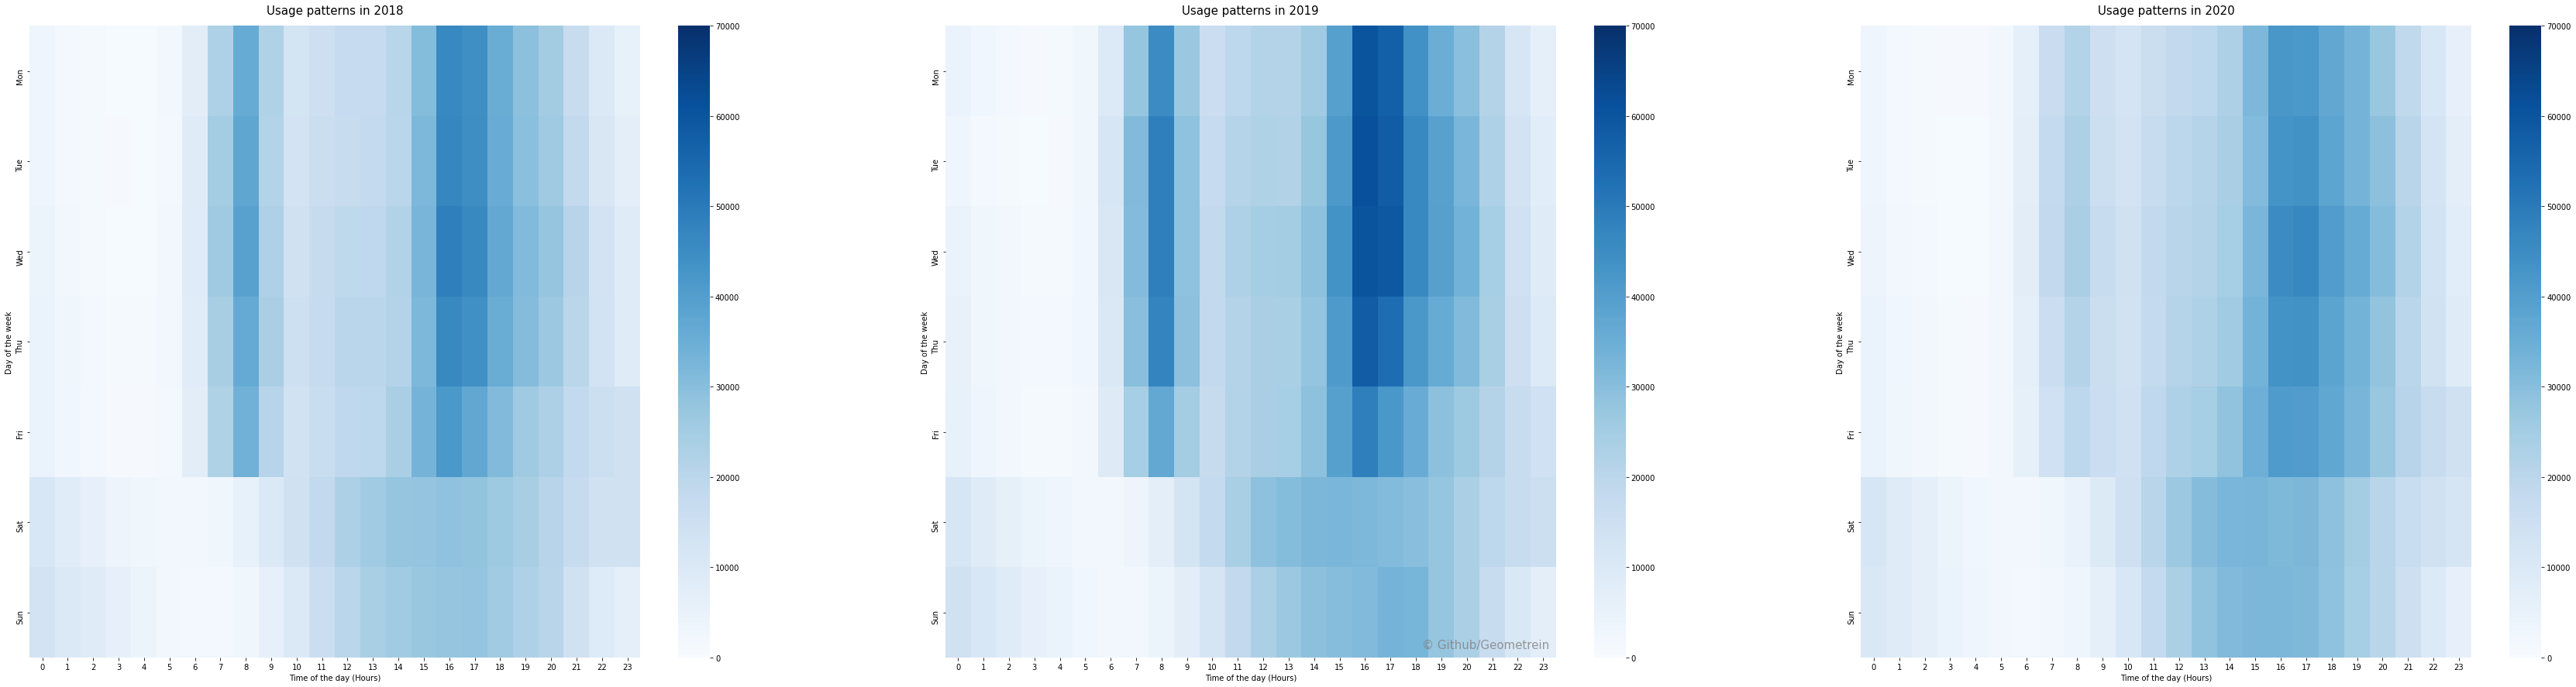

In [38]:
def yearlyHeatmap(dataframe):
    """
    This function plots the number of trips by weekday and hour of the day.
    """
    weekdays = ["Mon", "Tue","Wed", "Thu", "Fri", "Sat", "Sun"]
    
    # Data
    df = dataframe.copy()

    df["hour"] = pd.DatetimeIndex(df['departure']).hour
    df["weekday"] = pd.DatetimeIndex(df['departure']).weekday

    df_2018 = df[df['departure'].dt.year == 2018]
    df_2019 = df[df['departure'].dt.year == 2019]
    df_2020 = df[df['departure'].dt.year == 2020]

    daily_activity_2018 = df_2018.groupby(by=['weekday','hour']).count()['departure_name'].unstack()
    daily_activity_2019 = df_2019.groupby(by=['weekday','hour']).count()['departure_name'].unstack()
    daily_activity_2020 = df_2020.groupby(by=['weekday','hour']).count()['departure_name'].unstack()

    # Figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(60,15))

    sns.heatmap(daily_activity_2018, ax=ax1, robust=True, vmin=0, vmax=70000, cmap="Blues", yticklabels=weekdays)
    sns.heatmap(daily_activity_2019, ax=ax2, robust=True, vmin=0, vmax=70000, cmap="Blues", yticklabels=weekdays)
    sns.heatmap(daily_activity_2020, ax=ax3, robust=True, vmin=0, vmax=70000, cmap="Blues", yticklabels=weekdays)

    # Labeling Axes
    ax1.set_title("Usage patterns in 2018", fontsize= 15, pad = 15)    
    ax2.set_title("Usage patterns in 2019", fontsize= 15, pad = 15)
    ax3.set_title("Usage patterns in 2020", fontsize= 15,pad = 15)

    ax1.set(xlabel="Time of the day (Hours)", ylabel="Day of the week")
    ax2.set(xlabel="Time of the day (Hours)", ylabel="Day of the week")
    ax3.set(xlabel="Time of the day (Hours)", ylabel="Day of the week")

    # Watermark
    ax2.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax2.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.8)


yearlyHeatmap(dataframe)

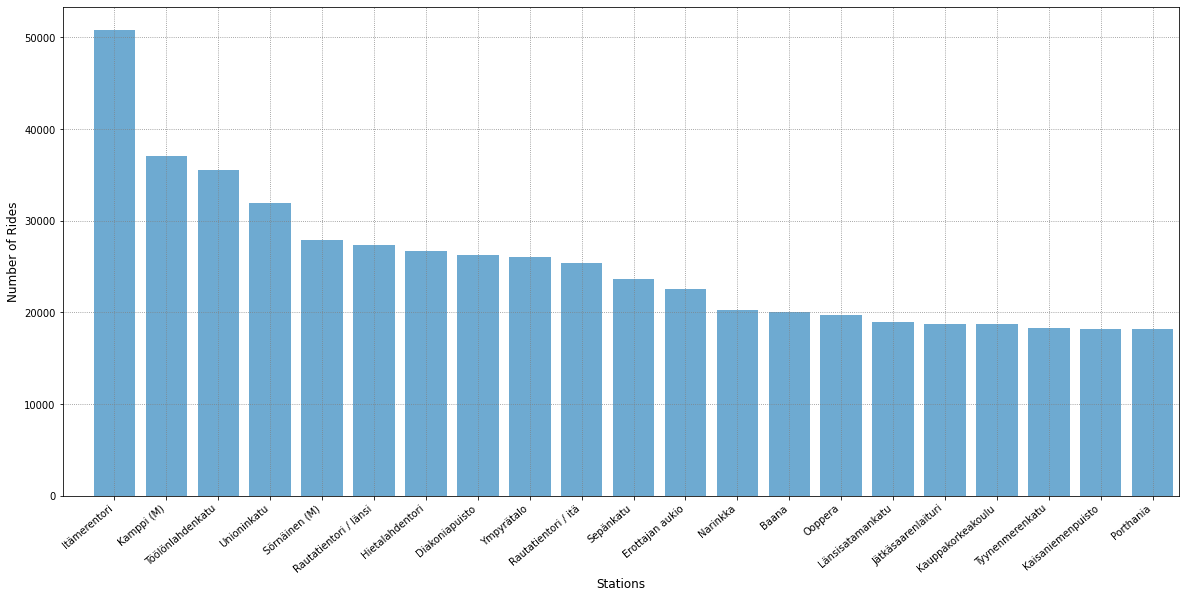

In [39]:
def topDepartureStantions(dataframe):
    """
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == 2017]

    # Figure
    fig = plt.figure(figsize=(20,9))
    ax = sns.countplot(x="departure_name", color = BLUE, data=df, order = df['departure_name'].value_counts().index)

    # Labeling Axes
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.xlabel("Stations", fontsize= 12, x = 0.5)
    plt.ylabel("Number of Rides", fontsize= 12)
    plt.xlim(-1,20.5)

    # Adding Grid
    plt.grid(linestyle=":", color='grey')

topDepartureStantions(dataframe)

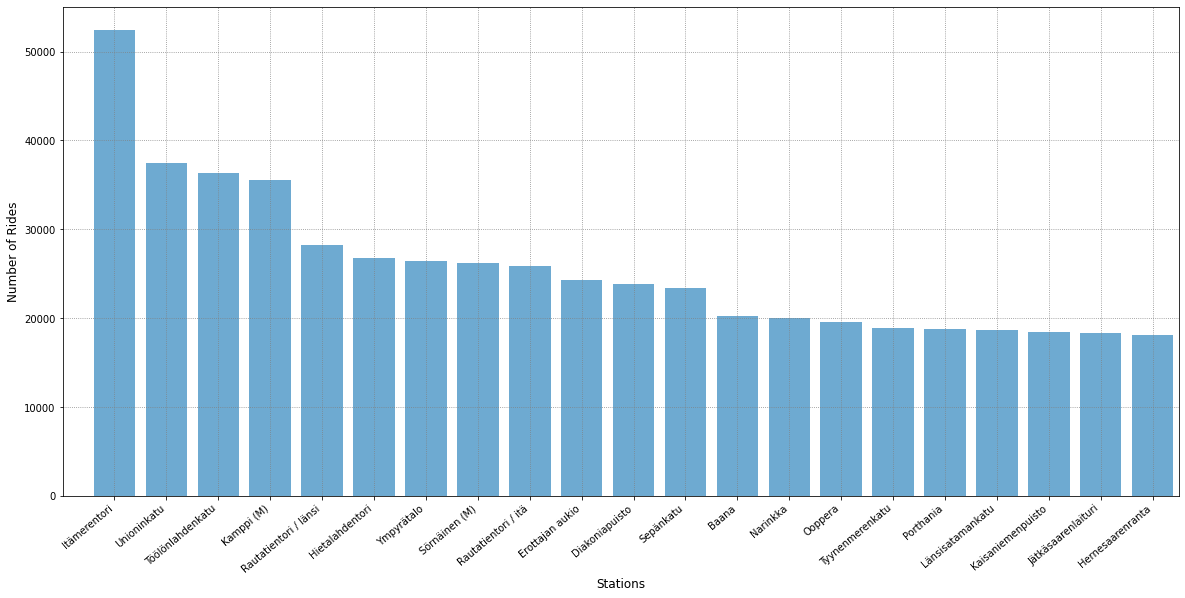

In [40]:
def topReturnStantions(dataframe):
    """
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == 2017]

    # Figure
    fig = plt.figure(figsize=(20,9))
    ax = sns.countplot(x="return_name", color = BLUE, data=df, order = df['return_name'].value_counts().index)

    # Labeling Axes
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.xlabel("Stations", fontsize= 12, x = 0.5)
    plt.ylabel("Number of Rides", fontsize= 12)
    plt.xlim(-1,20.5)

    # Adding Grid
    plt.grid(linestyle=":", color='grey')

topReturnStantions(dataframe)

In [41]:
def tripsByYear(dataframe):
    """
    This function prints the weekly number of trips over the years
    """
    # Data 
    df = dataframe.copy()
    df_2017 = df[df['departure'].dt.year == 2017]
    df_2018 = df[df['departure'].dt.year == 2018]
    df_2019 = df[df['departure'].dt.year == 2019]
    df_2020 = df[df['departure'].dt.year == 2020]

    #df_over_time = df.groupby(df['departure'].dt.month).size().reset_index(name='count')
    df_2017 = df_2017.groupby(df['departure'].dt.week).size().reset_index(name='count')
    df_2018 = df_2018.groupby(df['departure'].dt.week).size().reset_index(name='count')
    df_2019 = df_2019.groupby(df['departure'].dt.week).size().reset_index(name='count')
    df_2020 = df_2020.groupby(df['departure'].dt.week).size().reset_index(name='count')

    # Figure
    fig, ax = plt.subplots(figsize=(20,9))
    plt.plot(df_2017["departure"], df_2017["count"], color= BLUE)
    plt.plot(df_2018["departure"], df_2018["count"])
    plt.plot(df_2019["departure"], df_2019["count"])
    plt.plot(df_2020["departure"], df_2020["count"])


    plt.axvline(25, color="grey", linestyle=':', linewidth=2 ) # midsumer
    plt.text(25*1.01, 25000, 'Juhannus', color = "grey", fontsize= 12)

    # Labels
    ax.set_title("Weekly Number of Rides", fontsize= 15, pad= 20)
    ax.set_ylabel("Number of trips", fontsize=12)
    ax.set_xlabel("Years", fontsize=12)

    # Grid & Legend
    plt.grid(linestyle=":", color='grey')
    plt.legend(["2017","2018","2019","2020"])

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    plt.show()

# function call is commented for performance reasons
#tripsByYear(dataframe)

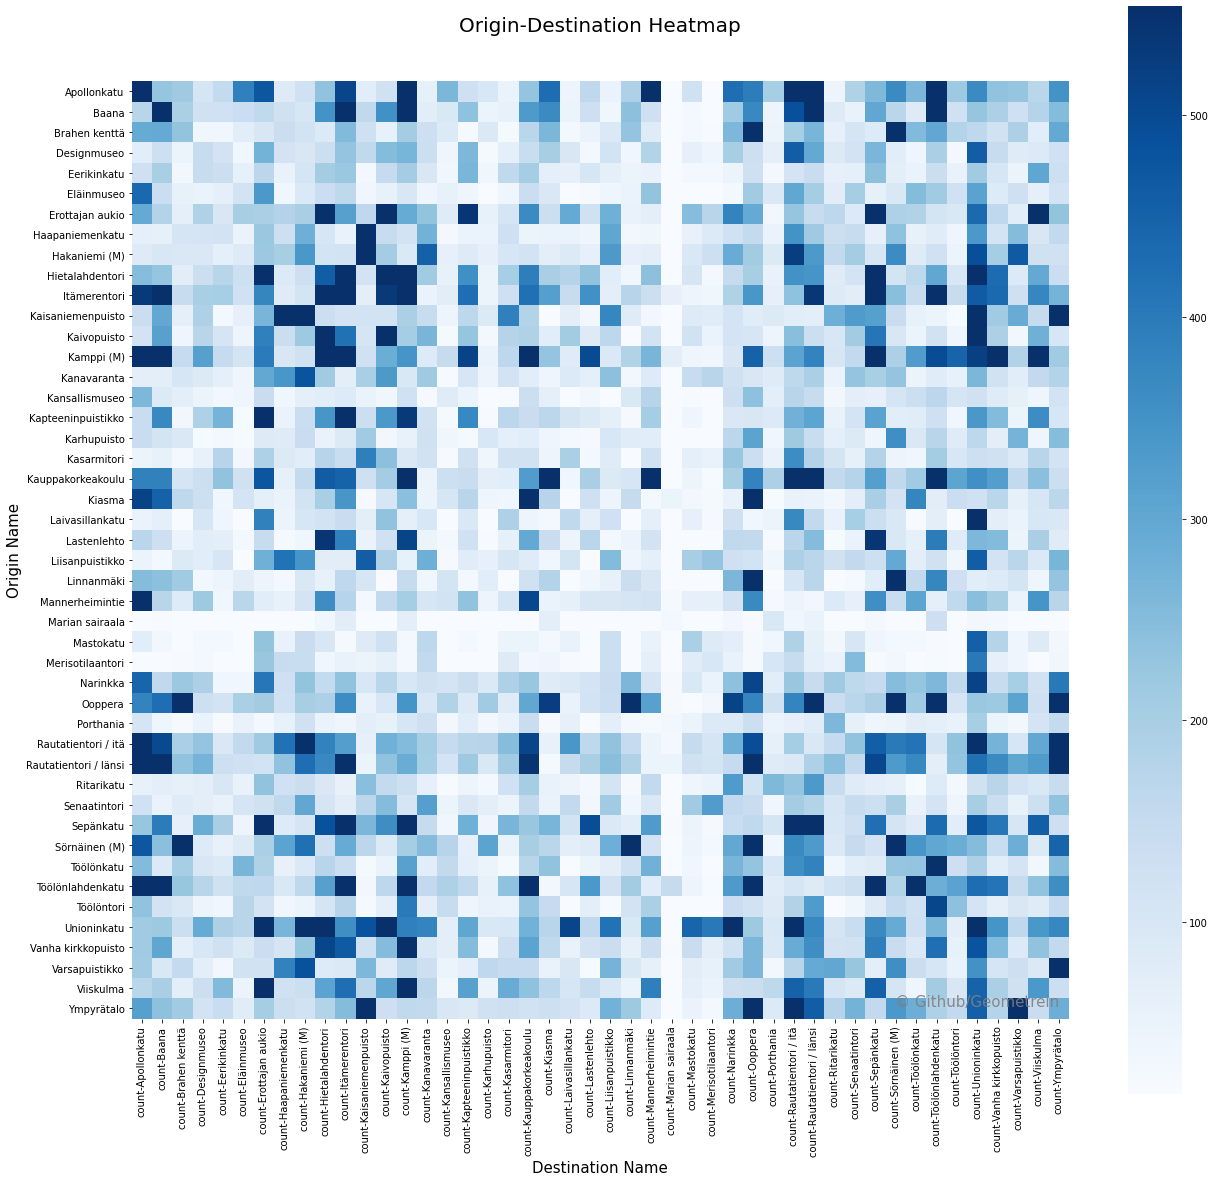

In [42]:
def odHeatmap(dataframe, year=2016):
    """
    This function Prints Origin-Destination heatmap for a given year.
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]
    dff = df.groupby(['departure_name', 'return_name']).size()
    dff = dff.sort_values(ascending=False)
    dff = dff.reset_index()
    dff.columns.values[2] = "count"
    #dff = dff[:50] 

    # Color scale for heatmap
    min_value = dff["count"].quantile(0.05)
    max_value = dff["count"].quantile(0.95)

    # Pivot
    dff = dff.pivot_table(index='departure_name', columns="return_name", fill_value=0)
    dff.sort_index(level=0, ascending=True, inplace=True)

    # Figure
    fig, ax = plt.subplots(figsize=(21,20))
    sns.heatmap(dff,vmin=min_value,vmax=max_value, cmap="Blues",square=True)
    
    # Labeling
    ax.set_title('Origin-Destination Heatmap', fontdict={"fontsize":20}, pad = 50)
    ax.set_xlabel("Destination Name", fontsize= 15, x = 0.5)
    ax.set_ylabel("Origin Name", fontsize= 15)

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

odHeatmap(dataframe)

In [48]:

def mapPlot(dataframe, year = 2020):
    """
    This function prints an interactive bubble plot by destination locations for a given year.
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]
    #df = df[:1000]
    df.dropna(inplace=True)
    df['freq'] = df.groupby('departure_name')['departure_name'].transform('count')
    #print(df.isna().sum())
    df["name"] = df["departure_name"]
    df = df[["name", "freq"]]
    df = df.drop_duplicates(subset=['name'])
    freq_dict = dict(zip(df.name, df.freq))

    df_stations = pd.read_csv("data/downloaded_data/station_coordinates.csv", index_col=False)
    df_stations = df_stations[df_stations["latitude"]<=60.254011]
    #print(df_stations.head())
    df_stations['freq']= df_stations['name'].map(freq_dict)
    #print(df_stations.head(), df_stations.isna().sum(), len(df_stations))
    df_stations["freq_adj"] = df_stations['freq']/(df_stations['freq'].median()/3)
    df_stations.fillna(1, inplace=True)
    df_stations.dropna(inplace=True)

    # Map
    hel_map = folium.Map([60.1975594, 24.9320720], zoom_start=12)
    folium.TileLayer('cartodbdark_matter').add_to(hel_map)


    for index, row in df_stations.iterrows():
        folium.CircleMarker([row['latitude'],row['longitude']],
                        radius=row["freq_adj"],
                        popup=row['freq'],
                        color="#eab544",
                        fill_color="#eab544", # divvy color
                    ).add_to(hel_map)

    display(hel_map)
    
# If the function call is commented its for performance reasons
mapPlot(dataframe)

In [47]:
def heatMapPlot(dataframe, year = 2020):
    """
    This function prints an interactive heatmap by destination locations for a given year.
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]

    df.dropna(inplace=True)
    df['freq'] = df.groupby('departure_name')['departure_name'].transform('count')
    

    # Map
    hel_map = folium.Map([60.1975594, 24.9320720], zoom_start=12)
    folium.TileLayer('cartodbdark_matter').add_to(hel_map)

    stationArr = df[['departure_latitude', 'departure_longitude']].to_numpy()
    hel_map.add_child(plugins.HeatMap(stationArr, radius=15))

    display(hel_map)
    
# function call is commented for performance reasons
#heatMapPlot(dataframe)
